# Principal Component Analysis

In [1]:
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score

import seaborn as sns
from matplotlib import pyplot as plt

%config Completer.use_jedi = False

Think of the predictors in your dataset as dimensions in what we can usefully call "feature space". If we're predicting house prices, then we might have a 'square feet' dimension or a 'number of bathrooms' dimension, etc. Then each record (of a house or a house sale, say) would be represented as a point (or vector) in this feature space. Some would score higher on the 'latitude' dimension or lower on the 'number of bedrooms' dimension, or whatever.

One difficulty is that, despite our working nomenclature, these things aren't really *dimensions* in the truest sense, since they're not independent of each other. When we talk about the x-, y-, and z-dimensions of Euclidean 3-space, for example, one important feature is that values of x have no bearing (per se) on values of y or of z. I can move three units along the x-dimension without changing my y- or z-position.

But the same thing is generally not true for datasets. When I increase my position along the 'number of bedrooms' dimension (or, better, *direction*), I also tend to increase my position along, say, the 'square feet' direction as well.

This is problematic for a couple reasons: One is that my model could be in effect "double-counting" certain features of my signal, which can lead to overfit models. And if my goal is inference or explanation, then I'm going to have a very hard time distinguishing between the idea that the number of bedrooms is what's *really* predictive of housing prices and the idea that the number of square feet is what's really so predictive.

Within a predictive lense, sometimes we may have a feature space that is so large (often as a product of OneHotEncoding) that there is no concievable way to produce a model that is not highly overfit to the training data. 

The idea behind Principal Component Analysis (PCA) is to transform our dataset into something more useful for building models. What we want to do is to build new dimensions (predictors) out of the dimensions we are given in such a way that:

(1) each dimension we draw captures as much of the remaining variance among our predictors as possible; and <br/>
(2) each dimension we draw is orthogonal to the ones we've already drawn.

## Motivation

Think back to multiple linear regression for a moment.

The fundamental idea is that I can get a better prediction for my dependent variable by considering a *linear combination of my predictors* than I can get by considering any one predictor by itself.

$\rightarrow$ **PCA insight**: If the combinations of predictors work better than the predictors themselves, then let's just treat the combinations as our primary dimensions!

But one problem with having lots of predictors is that it raises the chance that some will be nearly *collinear*.

$\rightarrow$ **PCA insight**: Since we're reconstructing our dimensions anyway, let's make sure that the dimensions we construct are mutually orthogonal! <br/>
$\rightarrow$ **PCA insight**: Moreover, since we'll be capturing much of the variance among our predictors in the first few dimensions we construct, we'll be able in effect to *reduce  the dimensionality* of our problem. Thus PCA is a fundamental tool in *dimensionality reduction*.

In [2]:
cars = pd.read_csv('cars.csv')

In [3]:
cars.head()

,mpg,cylinders,cubicinches,hp,weightlbs,time-to-60,year,brand
0,14.0,8,350,165,4209,12,1972,US.
1,31.9,4,89,71,1925,14,1980,Europe.
2,17.0,8,302,140,3449,11,1971,US.
3,15.0,8,400,150,3761,10,1971,US.
4,30.5,4,98,63,2051,17,1978,US.


In [4]:
cars.dtypes

mpg             float64
 cylinders        int64
 cubicinches     object
 hp               int64
 weightlbs       object
 time-to-60       int64
 year             int64
 brand           object
dtype: object

**Data Formatting**

In the cell below, reformat the column names so 
- There are not preceeding or trailing spaces 
- All spaces and dashes have been replaced with underscores

In [5]:
# Your code here
cars.columns = [x.strip().replace(' ', '_').replace('-', '_') for x in cars.columns]

In [6]:
cars.columns

Index(['mpg', 'cylinders', 'cubicinches', 'hp', 'weightlbs', 'time_to_60',
       'year', 'brand'],
      dtype='object')

In the cell below, change `'cubicinches'` and `'weightlbs'` to a numeric datatype. Replace non convertable observations to `np.nan`.

In [7]:
# Your code here
cars.cubicinches = pd.to_numeric(cars.cubicinches, errors='coerce')
cars.weightlbs = pd.to_numeric(cars.weightlbs, errors='coerce')

In the cell below, seperate `'mpg'` from the rest of the data, and create a train test split. 
- Assign the `'mpg'` column to the variable `y`.
- Assign all other columns to the variable `X`.
- Create a train test split with a `random_state` of 20


In [8]:
# Your code here
y = cars.mpg
X = cars.drop(columns = 'mpg')

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 20)

In [9]:
number_selector = make_column_selector(dtype_include='number')
object_selector = make_column_selector(dtype_include='object')

column_transform = make_column_transformer(
                    (StandardScaler(), number_selector),
                    (OneHotEncoder(), object_selector),
                    remainder='passthrough')

preprocessing = make_pipeline(column_transform, SimpleImputer())

In [10]:
preprocessing.fit(X_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdadec9a250>),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fdadec9a5b0>)])),
                ('simpleimputer', SimpleImputer())])

In [11]:
X_tr_pp = preprocessing.transform(X_train)
X_te_pp = preprocessing.transform(X_test)

In [12]:
# Let's construct a linear regression

lr = LinearRegression().fit(X_tr_pp, y_train)

# Score on train
lr.score(X_tr_pp, y_train)

0.8194994945551486

In [13]:
# Score on test

lr.score(X_te_pp, y_test)

0.7735358857922057

In [14]:
# Get the coefficients of the best-fit hyperplane

lr.coef_

array([-1.55471557,  2.18857575, -1.15449626, -4.68100076, -0.26656104,
        2.60363016,  0.70774264,  0.91202361, -1.61976625])

Thus, our best-fit hyperplane is given by:

$- 1.555\times cyl\_sd + 2.189\times in^3\_sd - 1.154\times hp\_sd - 4.681\times lbs.\_sd  - 0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

## Eigenvalues and Eigenvectors

The key idea is to diagonalize (i.e. find the eigendecomposition of) the covariance matrix. The decomposition will produce a set of orthogonal vectors that explain as much of the remaining variance as possible. These are our [principal components](https://math.stackexchange.com/questions/23596/why-is-the-eigenvector-of-a-covariance-matrix-equal-to-a-principal-component).

In [15]:
# Covariance Matrix (looking at variance between all features)
X_train.cov()

,cylinders,cubicinches,hp,weightlbs,time_to_60,year
cylinders,2.888078,174.589621,57.410124,1273.768434,-2.910759,-1.786413
cubicinches,174.589621,11680.199590,3966.867039,84124.377026,-199.495790,-127.292449
hp,57.410124,3966.867039,1633.480307,29046.361693,-87.992598,-51.598863
weightlbs,1273.768434,84124.377026,29046.361693,707678.272142,-1183.859184,-727.437009
time_to_60,-2.910759,-199.495790,-87.992598,-1183.859184,8.609728,2.966825
year,-1.786413,-127.292449,-51.598863,-727.437009,2.966825,13.614327


In [16]:
matrix = np.array([[0,1], [1,0]])
matrix

array([[0, 1],
       [1, 0]])

In [17]:
vector = [5,2]
matrix.dot(vector)

array([2, 5])

In [18]:
np.linalg.eig(matrix)

(array([ 1., -1.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [19]:
matrix.dot([0.70710678,0.70710678])

array([0.70710678, 0.70710678])

In [27]:
matrix.dot([-0.70710678,0.70710678])

array([ 0.70710678, -0.70710678])

The definition of an eigenvector is: $\vec{x}$ is an eigenvector of the matrix $A$ if $A\vec{x} = \lambda\vec{x}$, for some scalar $\lambda$. That is, the vector is oriented in just such a direction that multiplying the matrix by it serves only to lengthen or shorten the original vector.

Suppose we have the matrix
$A =
\begin{bmatrix}
a_{11} & a_{12} \\
a_{21} & a_{22} \\
\end{bmatrix}
$.

Let's calculate the eigendecomposition of this matrix.

In order to do this, we set $(A - \lambda I)\vec{x} = 0$. One trivial solution is $\vec{x} = \vec{0}$, but if there are more interesting solutions, then it must be that $|A - \lambda I| = 0$, which is to say that some column vector in $A - \lambda I$ must be expressible as a linear combination of the other columns. (Otherwise, there would be no way to "undo" the multiplicative effect of a column vector on $\vec{x}$!) For more on this point, see [this page](http://www2.math.uconn.edu/~troby/math2210f16/LT/sec1_7.pdf).

So we have:

$\begin{vmatrix}
a_{11} - \lambda & a_{12} \\
a_{21} & a_{22} - \lambda
\end{vmatrix} = 0$

$(a_{11} - \lambda)(a_{22} - \lambda) - a_{12}a_{21} = 0$

$\lambda^2 - (a_{11} + a_{22})\lambda + a_{11}a_{22} - a_{12}a_{21}$

$\lambda = \frac{a_{11} + a_{22}\pm\sqrt{(a_{11} + a_{22})^2 + 4(a_{12}a_{21} - a_{11}a_{22})}}{2}$

Suppose e.g. we had

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix}$.

We can use the equation we just derived to solve for the eigenvalues of this matrix. Then we can plug *those* into our eigenvector definition to solve for the eigenvectors:

So:

### Eigenvalues

$\lambda = \frac{5+5\pm\sqrt{(5+5)^2+4(3\times 3 - 5\times 5)}}{2} = 5\pm\frac{\sqrt{36}}{2} = 2, 8$.

### Eigenvectors

Now we can plug those in. If we plug in $\lambda = 8$, then we get:

$\begin{bmatrix}
5-8 & 3 \\
3 & 5-8
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix}
=
\begin{bmatrix}
-3 & 3 \\
3 & -3
\end{bmatrix}
\begin{bmatrix}
x_1 \\
x_2
\end{bmatrix} = 0.$

So:

$-3x_1 + 3x_2 = 0$ (or $3x_1 - 3x_2 = 0$)

$x_1 = x_2$.

Therefore, we find that any 2 element column vector in which the two elements have equal magnitude and the same sign are eigenvectors for this matrix.

It is standard to scale eigenvectors to a magnitude of 1, and so we would write this eigenvector as
$\begin{bmatrix}
\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$.

If we plug in $\lambda = 2$, we find a second eigenvector equal to
$\begin{bmatrix}
-\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2}
\end{bmatrix}$. Therefore, we find that any 2 element column vector in which the two elements have equal magnitude and opposite signs are eigenvectors for this matrix.
 (I'll leave this as an exercise.)

**Thus we can express the full diagonalization of our matrix as follows**:

$A = \begin{bmatrix}
5 & 3 \\
3 & 5
\end{bmatrix} =
\begin{bmatrix}
\frac{\sqrt{2}}{2} & -\frac{\sqrt{2}}{2} \\
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}
\begin{bmatrix}
8 & 0 \\
0 & 2
\end{bmatrix}
\begin{bmatrix}
\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2} \\
-\frac{\sqrt{2}}{2} & \frac{\sqrt{2}}{2}
\end{bmatrix}$

### In Code

In [22]:
# We can use np.linalg.eig()

A = np.array([[5, 3], [3, 5]])
np.linalg.eig(A)

(array([8., 2.]),
 array([[ 0.70710678, -0.70710678],
        [ 0.70710678,  0.70710678]]))

In [ ]:
# Eigenvectors are columns [0.70710678,  0.70710678] and [-0.70710678,  0.70710678]

In [23]:
# np.linalg.eig(X) returns a double of NumPy arrays, the first containing
# the eigenvalues of X and the second containing the eigenvectors of X.

values, vectors = np.linalg.eig(A)

In [24]:
values

array([8., 2.])

In [25]:
# np.diag()

np.diag(values)

array([[8., 0.],
       [0., 2.]])

In [26]:
# Reconstruct A by multiplication

vectors.dot(np.diag(values)).dot(vectors.T)

array([[5., 3.],
       [3., 5.]])

## PCA by Hand

What follows is indebted to [Sebastian Raschka](http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html#pca-vs-lda).

In [28]:
X_tr_pp

array([[-0.91365933, -0.73374036, -0.75054527, ...,  0.        ,
         1.        ,  0.        ],
       [-0.91365933, -0.94710908, -1.46992382, ...,  1.        ,
         0.        ,  0.        ],
       [-0.91365933, -1.03060118, -0.72573911, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.91365933, -0.80795556, -0.42806522, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26623186, -0.24206462,  0.24170102, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26623186, -0.28844913,  0.3657318 , ...,  1.        ,
         0.        ,  0.        ]])

In [29]:
# We'll start by producing the covariance matrix for the columns of X_tr_pp.

cov_mat = np.cov(X_tr_pp, rowvar=False)
cov_mat.shape

(9, 9)

In [30]:
cov_mat

array([[ 1.00515464,  0.94565515,  0.84015601,  0.88175937, -0.58673216,
        -0.28635987, -0.15296792, -0.14492108,  0.297889  ],
       [ 0.94565515,  0.99484536,  0.90346127,  0.90612332, -0.62583216,
        -0.31755825, -0.15696376, -0.15637655,  0.31334032],
       [ 0.84015601,  0.90346127,  1.00515464,  0.8454713 , -0.74580856,
        -0.34779071, -0.11424734, -0.12220459,  0.23645192],
       [ 0.88175937,  0.90612332,  0.8454713 ,  0.98969072, -0.47464555,
        -0.23193238, -0.11376261, -0.16352081,  0.27728342],
       [-0.58673216, -0.62583216, -0.74580856, -0.47464555,  1.00515464,
         0.2754432 ,  0.10550315,  0.06139071, -0.16689386],
       [-0.28635987, -0.31755825, -0.34779071, -0.23193238,  0.2754432 ,
         1.00515464, -0.03993529,  0.05702989, -0.0170946 ],
       [-0.15296792, -0.15696376, -0.11424734, -0.11376261,  0.10550315,
        -0.03993529,  0.15453344, -0.03325403, -0.12127941],
       [-0.14492108, -0.15637655, -0.12220459, -0.16352081,  0

In [31]:
np.linalg.eig(cov_mat)

(array([4.38933267e+00, 9.22453671e-01, 6.05467320e-01, 2.25938398e-01,
        1.74183560e-01, 1.17666549e-01, 3.30715097e-02, 6.89997267e-02,
        1.86697863e-16]),
 array([[ 4.50493972e-01,  1.31516586e-01,  1.89377391e-01,
         -1.68669148e-01,  1.95013697e-01, -6.88498751e-01,
         -4.14419189e-01,  1.77880171e-01, -3.34616330e-15],
        [ 4.63752118e-01,  9.96079091e-02,  1.42972191e-01,
         -9.70945887e-02,  6.00289237e-02, -3.63338354e-02,
          8.28603022e-01,  2.31597158e-01,  1.27465869e-15],
        [ 4.55012282e-01, -4.77921413e-03, -1.42511891e-01,
          3.70538847e-01,  5.18532087e-02,  5.06832022e-01,
         -3.14650574e-01,  5.26079717e-01, -5.95082193e-16],
        [ 4.32607002e-01,  1.94139845e-01,  3.40880602e-01,
          3.19179467e-01, -5.00236660e-02,  1.80719400e-01,
         -7.44780853e-02, -7.18593718e-01,  1.99465910e-15],
        [-3.50473904e-01,  1.22681926e-01,  8.50838640e-01,
          8.02940529e-02,  1.45206459e-01,  1.

In [32]:
# Let's assign the results of eig(cov_mat) to a double of variables.

eigvals, eigvecs = np.linalg.eig(cov_mat)

In [33]:
# The columns of "eigvecs" are the eigenvectors!

eigvecs

array([[ 4.50493972e-01,  1.31516586e-01,  1.89377391e-01,
        -1.68669148e-01,  1.95013697e-01, -6.88498751e-01,
        -4.14419189e-01,  1.77880171e-01, -3.34616330e-15],
       [ 4.63752118e-01,  9.96079091e-02,  1.42972191e-01,
        -9.70945887e-02,  6.00289237e-02, -3.63338354e-02,
         8.28603022e-01,  2.31597158e-01,  1.27465869e-15],
       [ 4.55012282e-01, -4.77921413e-03, -1.42511891e-01,
         3.70538847e-01,  5.18532087e-02,  5.06832022e-01,
        -3.14650574e-01,  5.26079717e-01, -5.95082193e-16],
       [ 4.32607002e-01,  1.94139845e-01,  3.40880602e-01,
         3.19179467e-01, -5.00236660e-02,  1.80719400e-01,
        -7.44780853e-02, -7.18593718e-01,  1.99465910e-15],
       [-3.50473904e-01,  1.22681926e-01,  8.50838640e-01,
         8.02940529e-02,  1.45206459e-01,  1.50707875e-01,
        -4.19606454e-02,  2.93573136e-01, -4.44784847e-16],
       [-1.87712952e-01,  9.37897463e-01, -2.36414653e-01,
         1.38165552e-01, -3.27256299e-02, -4.891305

In [34]:
# The eigenvectors of the covariance matrix are our principal components.
# Let's look at the first three.

pcabh = np.vstack([row[:3] for row in eigvecs])

In [35]:
pcabh

array([[ 0.45049397,  0.13151659,  0.18937739],
       [ 0.46375212,  0.09960791,  0.14297219],
       [ 0.45501228, -0.00477921, -0.14251189],
       [ 0.432607  ,  0.19413984,  0.3408806 ],
       [-0.3504739 ,  0.12268193,  0.85083864],
       [-0.18771295,  0.93789746, -0.23641465],
       [-0.06777805, -0.12955236,  0.04148077],
       [-0.07298767, -0.02237399, -0.13206575],
       [ 0.14076571,  0.15192635,  0.09058497]])

Now, to transform our data points into the space defined by the principal components, we simply need to compute the dot-product of `X_tr_pp` with those principal components.

Why? Think about what this matrix product looks like:

We take a row of `X_tr_pp` and multiply it by a column of `pcabh`, pairwise. The row of `X_tr_pp` represents the values for the columns in the original space. The column of `pcabh` represents the weights we need on each of the original columns in order to transform a value into principal-component space. And so the product of these two matrices will be each row, transformed into principal-component space!

In [36]:
X_tr_pp[:5, :]

array([[-0.91365933, -0.73374036, -0.75054527, -0.54147778,  0.80251396,
         1.15654312,  0.        ,  1.        ,  0.        ],
       [-0.91365933, -0.94710908, -1.46992382, -1.24704389,  1.82755909,
        -0.74548261,  1.        ,  0.        ,  0.        ],
       [-0.91365933, -1.03060118, -0.72573911, -1.1099829 , -0.22253116,
        -1.28891854,  1.        ,  0.        ,  0.        ],
       [ 1.44612305,  2.37402138,  2.9703783 ,  0.10688025, -1.93093971,
        -1.5606365 ,  0.        ,  0.        ,  1.        ],
       [ 1.44612305,  1.3999468 ,  0.98588573,  1.29394754, -0.90589458,
        -0.74548261,  0.        ,  0.        ,  1.        ]])

In [37]:
X_tr_pp.dot(pcabh)[:5, :]

array([[-1.89897205,  0.86601574, -0.07822813],
       [-2.62748825, -1.05410688,  1.24863355],
       [-1.44778807, -1.80056717, -0.43845703],
       [ 4.26068429, -1.11546795, -0.95697458],
       [ 2.90725376, -0.08226684,  0.27065552]])

# Sklearn

In [38]:
# Naturally, sklearn has a shortcut for this!

pca = PCA(n_components=3) # Check out how `n_components` works

X_train_new = pca.fit_transform(X_tr_pp)

In [39]:
# Let's check out the explained variance

pca.explained_variance_

array([4.38933267, 0.92245367, 0.60546732])

In [40]:
# The ratio is often more informative

pca.explained_variance_ratio_

array([0.67144815, 0.14111024, 0.09261998])

In [41]:
# We can also check out the Principal Components themselves

pca.components_

array([[ 0.45049397,  0.46375212,  0.45501228,  0.432607  , -0.3504739 ,
        -0.18771295, -0.06777805, -0.07298767,  0.14076571],
       [-0.13151659, -0.09960791,  0.00477921, -0.19413984, -0.12268193,
        -0.93789746,  0.12955236,  0.02237399, -0.15192635],
       [ 0.18937739,  0.14297219, -0.14251189,  0.3408806 ,  0.85083864,
        -0.23641465,  0.04148077, -0.13206575,  0.09058497]])

In [42]:
X_train.columns

Index(['cylinders', 'cubicinches', 'hp', 'weightlbs', 'time_to_60', 'year',
       'brand'],
      dtype='object')

The results of our PCA are as follows: 

**PC1** = 0.450 * cylinders_sd + 0.464 * cubicinches_sd + 0.455 * hp_sd + 0.433 * 𝑙𝑏𝑠_𝑠𝑑 - 0.350 * time-to-60_sd - 0.188 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.141 * US

**PC2** = -0.132 * cylinders_sd - 0.1 * cubicinches_sd + 0.005 * hp_sd  -0.194 * 𝑙𝑏𝑠_𝑠𝑑 - 0.123 * time-to-60_sd - 0.938 * year_sd + 0.13 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.189 * cylinders_sd + 0.142 * cubicinches_sd - 0.143 * hp_sd + 0.341 * 𝑙𝑏𝑠_𝑠𝑑 + 0.851 * time-to-60_sd - 0.236 * year_sd - 0.041 * Europe - 0.132 * Japan + 0.091 * US

## Orthogonality

These principal components should also be mutually orthogonal. If they are, then the dot product of any two of them should be 0. Let's check!

In [43]:
pca.components_[0].dot(pca.components_[1])

-1.3877787807814457e-17

In [44]:
pca.components_[0].dot(pca.components_[2])

-1.3877787807814457e-17

In [45]:
pca.components_[1].dot(pca.components_[2])

-4.163336342344337e-17

## Transformed dimensions have zero correlation

In [46]:
np.corrcoef(X_train_new.T)

array([[ 1.00000000e+00,  7.82113286e-17, -6.17840773e-17],
       [ 7.82113286e-17,  1.00000000e+00,  3.17023317e-16],
       [-6.17840773e-17,  3.17023317e-16,  1.00000000e+00]])

## Visualizations

In [47]:
X_test_new = pca.transform(X_te_pp)

In [48]:
# Reassembling the whole dataset for the sake of visualization

X_transformed = np.vstack([X_train_new, X_test_new])
y_new = np.concatenate([y_train, y_test])

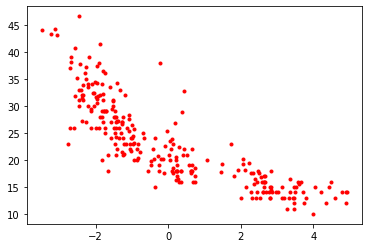

In [52]:
f, a = plt.subplots()
a.plot(X_transformed[:, 0], y_new, 'r.');

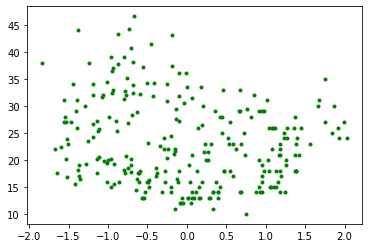

In [53]:
f, a = plt.subplots()
a.plot(X_transformed[:, 1], y_new, 'g.');

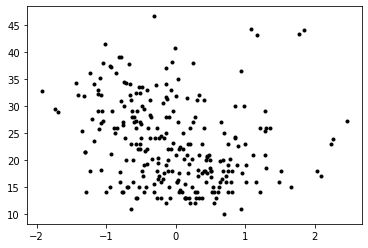

In [54]:
f, a = plt.subplots()
a.plot(X_transformed[:, 2], y_new, 'k.');

In [55]:
df = pd.DataFrame(np.hstack([X_transformed, y_new[:, np.newaxis]]),
                  columns=['PC1', 'PC2', 'PC3', 'y'])
df.head()

,PC1,PC2,PC3,y
0,-1.962898,-0.797889,-0.120675,31.3
1,-2.691414,1.122234,1.206187,26.0
2,-1.511714,1.868694,-0.480904,30.0
3,4.196758,1.183595,-0.999421,14.0
4,2.843328,0.150394,0.228209,15.0


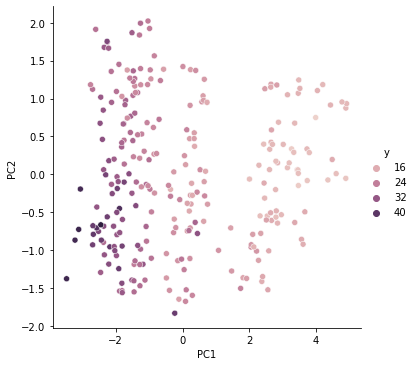

In [56]:
sns.relplot(data=df,
            x='PC1',
            y='PC2',
           hue='y');

## Relation to Linear Regression

Question: Is the first principal component the same line we would get if we constructed an ordinary least-squares regression line?

Answer: No. The best-fit line minimizes the sum of squared errors, i.e. the minimum sum of ("vertical") distances between the predictions and the real values of the dependent variable. Principal Component Analysis, by contrast, is not a modeling procedure and so has no target. The first principal component thus cannot minimize the sum of distances between predictions and real values; instead, it minimizes the sum of ("perpendicular") distances between the data points and *it (the line) itself*.

Suppose we look at MPG vs. z-scores of weight in lbs. Let's make a scatter plot:

In [57]:
X_tr_pp

array([[-0.91365933, -0.73374036, -0.75054527, ...,  0.        ,
         1.        ,  0.        ],
       [-0.91365933, -0.94710908, -1.46992382, ...,  1.        ,
         0.        ,  0.        ],
       [-0.91365933, -1.03060118, -0.72573911, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-0.91365933, -0.80795556, -0.42806522, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26623186, -0.24206462,  0.24170102, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26623186, -0.28844913,  0.3657318 , ...,  1.        ,
         0.        ,  0.        ]])

In [58]:
X_tr_pp[:, 1]

array([-7.33740359e-01, -9.47109075e-01, -1.03060118e+00,  2.37402138e+00,
        1.39994680e+00,  2.37402138e+00,  9.54655569e-01,  4.72256733e-01,
        1.86379184e+00, -9.37832174e-01, -9.47109075e-01,  1.40922370e+00,
        1.10308598e+00, -5.48202345e-01,  1.10308598e+00, -1.11409329e+00,
       -7.24463458e-01,  1.00104007e+00, -1.11409329e+00, -7.70847962e-01,
       -4.46156437e-01,  1.10308598e+00,  1.40922370e+00,  3.05272520e-01,
        1.10308598e+00, -8.72893869e-01, -9.47109075e-01,  1.86379184e+00,
       -3.34833629e-01, -8.54340068e-01,  3.05272520e-01,  4.72256733e-01,
        1.86379184e+00,  3.05272520e-01, -1.00277048e+00, -1.07698568e+00,
        4.72256733e-01, -7.15186557e-01,  2.95995619e-01,  1.39994680e+00,
       -9.37832174e-01, -5.94586848e-01, -6.31694451e-01,  9.54655569e-01,
        1.86379184e+00, -5.38925444e-01,  9.73209371e-01, -9.37832174e-01,
        4.72256733e-01,  1.86379184e+00,  2.23486787e+00, -7.33740359e-01,
       -9.47109075e-01, -

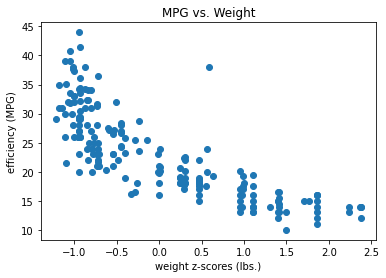

In [59]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight');

Let's add the best-fit line:

In [60]:
beta1 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).coef_
beta0 = LinearRegression().fit(X_tr_pp[:, 1].reshape(-1, 1),
                               y_train).intercept_

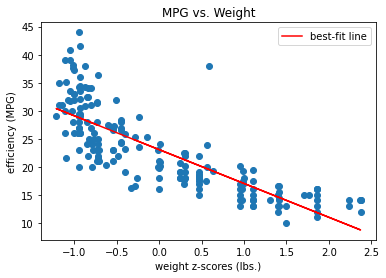

In [61]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Now let's see what the principal component looks like. We'll make use of the `inverse_transform()` method of `PCA()` objects.

In [62]:
pc1 = PCA(n_components=1).fit(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc = pc1.transform(np.concatenate((X_tr_pp[:, 1].reshape(-1, 1),
                                 y_train.values.reshape(-1, 1)),
                                axis=1))

pc_inv = pc1.inverse_transform(pc)

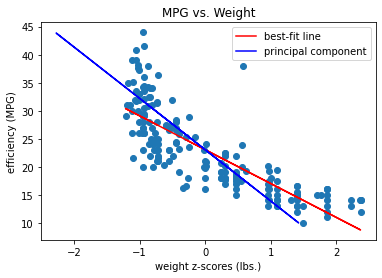

In [63]:
f, a = plt.subplots()

a.scatter(X_tr_pp[:, 1], y_train)
a.plot(X_tr_pp[:, 1],
       beta1[0] * X_tr_pp[:, 1] + beta0,
      c='r', label='best-fit line')
a.plot(pc_inv[:, 0],
       pc_inv[:, 1],
      c='b', label='principal component')
a.set_xlabel('weight z-scores (lbs.)')
a.set_ylabel('efficiency (MPG)')
a.set_title('MPG vs. Weight')
plt.legend();

Check out this post, to which I am indebted, for more on this subtle point: https://shankarmsy.github.io/posts/pca-vs-lr.html

## Modeling with New Dimensions

Now that we have optimized our features, we can build a new model with them!

In [64]:
lr_pca = LinearRegression()
lr_pca.fit(X_train_new, y_train)
lr_pca.score(X_train_new, y_train)

0.7942095288150963

In [65]:
X_test_new = pca.transform(X_te_pp)

In [66]:
lr_pca.score(X_test_new, y_test)

0.7161359404824603

In [67]:
lr_pca.coef_

array([-2.97363289, -1.16133279, -2.49280802])

Thus, our best-fit hyperplane is given by:

$-2.967\times PC1 - 1.162\times PC2 -2.486\times PC3$

Of course, since the principal components are just linear combinations of our original predictors, we could re-express this hyperplane in terms of those original predictors!

And if the PCA was worth anything, we should expect the new linear model to be *different from* the first!

Recall that we had:

**PC1** = 0.450 * cylinders_sd + 0.464 * cubicinches_sd + 0.455 * hp_sd + 0.433 * 𝑙𝑏𝑠_𝑠𝑑 - 0.350 * timeto60sd - 0.188 * year_sd - 0.068 * Europe - 0.073 * Japan + 0.141 * US

**PC2** = -0.132 * cylinders_sd - 0.1 * cubicinches_sd + 0.005 * hp_sd  -0.194 * 𝑙𝑏𝑠_𝑠𝑑 - 0.123 * timeto60sd - 0.938 * year_sd + 0.13 * Europe + 0.022 * Japan - 0.152 * US

**PC3** = 0.189 * cylinders_sd + 0.142 * cubicinches_sd - 0.143 * hp_sd + 0.341 * 𝑙𝑏𝑠_𝑠𝑑 + 0.851 * timeto60sd - 0.236 * year_sd - 0.041 * Europe - 0.132 * Japan + 0.091 * US

Therefore, our new PCA-made hyperplane can be expressed as:

$-2.967\times(0.450 * cylinderssd + 0.464 * cubicinchessd + 0.455 * hpsd + 0.433 * 𝑙𝑏𝑠𝑠𝑑 - 0.350 * timeto60sd - 0.188 * yearsd - 0.068 * Europe - 0.073 * Japan + 0.141 * US)$ <br/> $- 1.162\times(-0.132 * cylinderssd - 0.1 * cubicinchessd + 0.005 * hpsd -0.194 * 𝑙𝑏𝑠𝑠𝑑 - 0.123 * timeto60sd - 0.938 * yearsd + 0.13 * Europe + 0.022 * Japan - 0.152 * US)$ <br/> $- 2.486\times(0.189 * cylinderssd + 0.142 * cubicinchessd - 0.143 * hpsd + 0.341 * 𝑙𝑏𝑠𝑠𝑑 + 0.851 * timeto60sd - 0.236 * yearsd - 0.041 * Europe - 0.132 * Japan + 0.091 * US)$

Let's make these calculations:

In [68]:
def pca_original(feature_names, model, pca, class_index=1):
    """
    
    Returns the coefficients for a model that has been reduced
    with sklearn's PCA.
    
    """
    
    coeffs = {}
    # For multi class classification problems, model.coef_
    # returns a matrix of coefficients for each class
    # If model.coef_.shape[1] exists and is not 0
    # then the coefficients are collected for the desired
    # class
    try:
        if model.coef_.shape[1]:
            weights = model.coef_[class_index]
        else:
            weights = model.coef_
    except:
        weights = model.coef_
    
    for idx in range(len(feature_names)):
        coeffs[feature_names[idx]] = np.round(weights @ pca.components_[:,idx], 3)
    return coeffs

In [69]:
feature_names = ['cylinders_sd', 'cubicinches_sd', 'horsepower_sd', 
                 'weightlbs_sd','timeto60_sd', 'year_sd', 'Europe',
                'Japan', 'US']

pca_original(feature_names, lr_pca, pca)

{'cylinders_sd': -1.659,
 'cubicinches_sd': -1.62,
 'horsepower_sd': -1.003,
 'weightlbs_sd': -1.911,
 'timeto60_sd': -0.936,
 'year_sd': 2.237,
 'Europe': -0.052,
 'Japan': 0.52,
 'US': -0.468}

So our best-fit hyperplane using PCA is:

$-1.659\times cyl\_sd -1.62\times in^3\_sd-1.003\times hp\_sd-1.911\times lbs.\_sd -0.936\times time_{60}\_sd + 2.237\times yr\_sd -0.052\times brand_{Europe} + 0.52\times brand_{Japan} -0.468\times brand_{US}$


Recall that our first linear regression model had:

$- 1.555\times cyl\_sd + 2.189\times in^3\_sd - 1.154\times hp\_sd - 4.681\times lbs.\_sd  - 0.267\times time_{60}\_sd + 2.604\times yr\_sd + 0.708\times brand_{Europe} + 0.912\times brand_{Japan} - 1.620\times brand_{US}$

which is clearly a different hyperplane.

# Importance of scaling

In [70]:
from sklearn.datasets import load_wine
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [71]:
unscaled = make_pipeline(PCA(.95), LogisticRegression())
scaled = make_pipeline(StandardScaler(), PCA(.95), LogisticRegression())
data = load_wine()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']

In [72]:
cross_val_score(unscaled, X, y)

array([0.63888889, 0.61111111, 0.72222222, 0.74285714, 0.8       ])

In [73]:
cross_val_score(scaled, X, y)

array([0.97222222, 0.94444444, 1.        , 1.        , 1.        ])

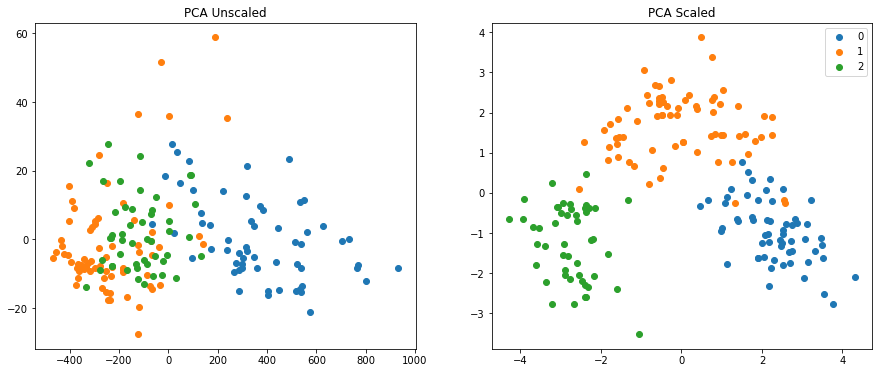

In [74]:
pca = PCA(2)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)
X_pca = pd.DataFrame(X_pca, columns=['f1', 'f2'])
X_scaled_pca = pca.fit_transform(X_scaled)
X_scaled_pca = pd.DataFrame(X_scaled_pca, columns=['f1', 'f2'])

fig, ax = plt.subplots(1,2, figsize=(15,6))
for label in pd.Series(y).unique():
    frame = X_pca[y==label]
    frame_scaled = X_scaled_pca[y==label]
    ax[0].scatter(frame.f1, frame.f2, label=label)
    ax[1].scatter(frame_scaled.f1, frame_scaled.f2, label=label)
ax[0].set_title('PCA Unscaled')
ax[1].set_title('PCA Scaled')
plt.legend();

# Selecting `n_components`.

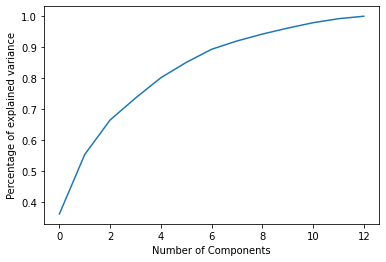

In [75]:
pca = PCA().fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumulative_variance)
plt.xlabel('Number of Components')
plt.ylabel('Percentage of explained variance');

In [76]:
pca = PCA(12)
pipeline = make_pipeline(StandardScaler(), pca, LogisticRegression())
cross_val_score(pipeline, X, y)

array([0.97222222, 0.97222222, 1.        , 1.        , 1.        ])

In [ ]:
pipeline.fit(X, y)

In [ ]:
pca_original(X.columns, pipeline.steps[-1][1], pipeline.steps[-2][1])

## Extra Resource

- [StatQuests Longform PCA video](https://www.youtube.com/watch?v=_UVHneBUBW0)
- [Three Blue One Brown Video on Eigan Vectors](https://www.youtube.com/watch?v=PFDu9oVAE-g)
- [Python Data Science Handbook - In Depth PCA](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html#:~:text=PCA%20is%20fundamentally%20a%20dimensionality,and%20engineering%2C%20and%20much%20more)